## Import libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import math 

from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

from sklearn.externals import joblib

import json

import warnings
warnings.filterwarnings('ignore')

## Some useful functions 

### Create Target Variable: duration

In [7]:
def create_target(df):
    # drop those records that have missing actual delivery time
    df = df[pd.notnull(df['actual_delivery_time'])]
    #df['created_at_datetime'] = df['created_at'].astype("datetime64[s]")
    #df['actual_delivery_time_datetime'] = df['actual_delivery_time'].astype("datetime64[s]")
    df['duration'] = df['actual_delivery_time'].astype("datetime64[s]") - df['created_at'].astype("datetime64[s]")
    df['duration'] = df['duration'] / np.timedelta64(1, 's')
    return df

### Create features based on order creation time
- create created_at_year, created_at_month, created_at_day, created_at_date, created_at_dayOfWeek, 
- created_at_time, created_at_hour, created_at_minute, created_at_second, created_at_isWeekend,
- created_at_isHoliday

In [8]:
def create_time_feature(df):       
    df['created_at_datetime'] = df['created_at'].astype("datetime64[s]")
    df['created_at_year'], df['created_at_month'], df['created_at_day'], df['created_at_date'], df['created_at_dayOfWeek'], df['created_at_time'], df['created_at_hour'], df['created_at_minute'], df['created_at_second'] = df['created_at_datetime'].dt.year, df['created_at_datetime'].dt.month, df['created_at_datetime'].dt.day, df['created_at_datetime'].dt.date, df['created_at_datetime'].dt.dayofweek, df['created_at_datetime'].dt.time, df['created_at_datetime'].dt.hour, df['created_at_datetime'].dt.minute, df['created_at_datetime'].dt.second
    df.loc[df['created_at_dayOfWeek'].isin([5, 6]), 'created_at_isWeekend'] = 1
    df.loc[df['created_at_dayOfWeek'].isin([0, 1, 2, 3, 4]), 'created_at_isWeekend'] = 0
    cal = calendar()
    holidays = cal.holidays(start=df['created_at_date'].min(), end=df['created_at_date'].max())
    df['created_at_isHoliday'] = np.where(df.created_at_datetime.dt.normalize().isin(holidays), 1, 0)
    return df

### Cap some numerical featuress, fill missing values, re-bin categorical features

In [9]:
def process_continuous_features(df):
    
    def bin_num(x, a=251, b=446):
        if x == a:
             return 'fast'
        elif x == b:
             return 'slow'
        else:
            return 'other'
    
    df['total_items'][(df['total_items'] > 20)] = 20
    df['subtotal'][df['subtotal'] > 12000] = 12000
    df['num_distinct_items'][df['num_distinct_items'] > 16] = 16
    df['min_item_price'][(df['min_item_price'] < 0)] = 0
    df['min_item_price'][(df['min_item_price'] > 5000)] = 5000

    df['max_item_price'][(df['max_item_price'] < 0)] = 0
    df['max_item_price'][(df['max_item_price'] > 5000)] = 5000

    df['total_onshift_dashers'][df['total_onshift_dashers'] < 0] = 0
    df['total_onshift_dashers'] = df['total_onshift_dashers'].fillna(int(df['total_onshift_dashers'].mean()))
    
    df['total_busy_dashers'][df['total_busy_dashers'] < 0] = 0
    df['total_busy_dashers'] = df['total_busy_dashers'].fillna(int(df['total_busy_dashers'].mean()))
    
    df['total_outstanding_orders'][df['total_outstanding_orders'] < 0] = 0
    df['total_outstanding_orders'] = df['total_outstanding_orders'].fillna(int(df['total_outstanding_orders'].mean()))
    
    df['estimated_order_place_duration_rebinned'] =  df['estimated_order_place_duration'].apply(bin_num)
    df['estimated_store_to_consumer_driving_duration'] = df['estimated_store_to_consumer_driving_duration'].fillna(int(df['estimated_store_to_consumer_driving_duration'].mean()))
    return df

### High Cardinality: store_id, calculate the number of orders for each store_id, then bucket it to cat features

In [10]:
def make_store_id_cont(df):
    store_counts_df = pd.DataFrame(df['store_id'].value_counts().reset_index().rename(columns={'index': 'store_id', 0: 'store_id_count'}))
    store_counts_df.columns = ['store_id', 'store_id_count']
    store_counts_df = store_counts_df.sort_values(by='store_id', ascending=True)
    df = pd.merge(df, store_counts_df, on='store_id', how='left')
    df['store_id_rebinned'] = df['store_id']
    df['store_id_rebinned'][(df['store_id_count'] <500) & (df['store_id_count'] >= 400)] = '[400, 500)'
    df['store_id_rebinned'][(df['store_id_count'] <400) & (df['store_id_count'] >= 200)] = '[200, 400)'
    df['store_id_rebinned'][(df['store_id_count'] <200) & (df['store_id_count'] >= 50)] = '[50, 200)'
    df['store_id_rebinned'][df['store_id_count'] <50] = '[0, 50)'
    return df,store_counts_df

### High Cardinality: store_category, calculate the number of orders for each store_category, then bucket it to cat features

In [11]:
def make_store_category_cont(df):
    df['store_primary_category'][df['store_primary_category'].isnull()] = 'Unknown'
    
    store_primary_category_counts_df = pd.DataFrame(df['store_primary_category'].value_counts().reset_index().rename(columns={'index': 'store_primary_category', 0: 'store_primary_category_count'}))
    store_primary_category_counts_df.columns = ['store_primary_category', 'store_primary_category_count']
    df = pd.merge(df, store_primary_category_counts_df, on='store_primary_category', how='left')
    
    df['store_primary_category_rebinned'] = df['store_primary_category']
    df['store_primary_category_rebinned'][df['store_primary_category_rebinned'].isnull()] = 'Unknown'
    df['store_primary_category_rebinned'][(df['store_primary_category_count'] <3000) & (df['store_primary_category_count'] >= 2000)] = '[2000, 3000)'
    df['store_primary_category_rebinned'][(df['store_primary_category_count'] <2000) & (df['store_primary_category_count'] >= 1000)] = '[1000, 2000)'
    df['store_primary_category_rebinned'][(df['store_primary_category_count'] <1000) & (df['store_primary_category_count'] >= 200)] = '[200, 1000)'
    df['store_primary_category_rebinned'][df['store_primary_category_count'] <200] = '[0, 200)'
    return df, store_primary_category_counts_df

### Impute market_id mising values

In [12]:
def impute_market_id(df):
    df['market_id'][df['market_id'].isnull()] = 0
    return df

### Impute order_protocol mising values and re-bin small buckets

In [13]:
def impute_order_protocol(df):
    df['order_protocol'][df['order_protocol'].isnull()] = 0
    df['order_protocol'].loc[df['order_protocol'] == 6] = 0
    df['order_protocol'].loc[df['order_protocol'] == 7] = 0
    return df

### Create Training/Testing set, cat/numerica features

In [14]:
def select_features(df,TrainOrScore):
    if TrainOrScore == 'Train':
        TrainFeatures = df[['duration', 'market_id', 'store_id_rebinned', 'store_primary_category_rebinned',
                            'order_protocol',  'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
                            'max_item_price','total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
                            'estimated_store_to_consumer_driving_duration', 'created_at_month', 'created_at_dayOfWeek',
                            'created_at_hour', 'created_at_isWeekend', 'created_at_isHoliday',
                            'estimated_order_place_duration_rebinned']]
    else:
        TrainFeatures = df[['market_id', 'store_id_rebinned', 'store_primary_category_rebinned',
                    'order_protocol',  'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
                    'max_item_price','total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
                    'estimated_store_to_consumer_driving_duration', 'created_at_month', 'created_at_dayOfWeek',
                    'created_at_hour', 'created_at_isWeekend', 'created_at_isHoliday',
                    'estimated_order_place_duration_rebinned']]
        
    TrainFeatures[['market_id', 'store_id_rebinned', 'store_primary_category_rebinned', 'order_protocol', 'created_at_month',
                   'created_at_dayOfWeek', 'created_at_hour',  'created_at_isWeekend', 'created_at_isHoliday', 
                   'estimated_order_place_duration_rebinned']] = TrainFeatures[['market_id', 'store_id_rebinned', 
                                                                               'store_primary_category_rebinned', 
                                                                                'order_protocol',
                                                                                'created_at_month', 'created_at_dayOfWeek',
                                                                                'created_at_hour',  'created_at_isWeekend',
                                                                                'created_at_isHoliday', 'estimated_order_place_duration_rebinned']].astype(object)
    NumFeatures = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',  'max_item_price',
                   'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
                   'estimated_store_to_consumer_driving_duration']
    CatFeatures = ['market_id', 'store_id_rebinned', 'store_primary_category_rebinned',  'order_protocol',
                   'created_at_month', 'created_at_dayOfWeek', 'created_at_hour', 'created_at_isWeekend',
                   'created_at_isHoliday', 'estimated_order_place_duration_rebinned']
    return TrainFeatures, NumFeatures, CatFeatures

### OneHot encoding for Categorical feature, scale numeric features

In [15]:
def scale_oneHot_X(input_x, features_num, features_cat):
    # scale numerical features
    input_x_scale = scale(input_x[features_num])
    
    # OneHot cat features
    le=LabelEncoder()
    enc = OneHotEncoder()
    Cat_Train = input_x[features_cat].apply(le.fit_transform)
    enc.fit(Cat_Train)
    input_x_oneHot = enc.transform(Cat_Train).toarray()
    
    output_x = pd.concat([pd.DataFrame(input_x_scale), pd.DataFrame(input_x_oneHot)], axis=1)
    output_x.columns = [i for i in range(output_x.shape[1])]
    return output_x 

## Models

### Linear Models

In [16]:
#Regular Linear Model
def lin_model(X_train, Y_train, X_test, Y_test):
    lm = linear_model.LinearRegression()
    lm.fit(X_train, Y_train)
    lm_predict_train = lm.predict(X_train)
    lm_predict_test = lm.predict(X_test)
    print("Root mean squared error for train: %.2f" % math.sqrt(mean_squared_error(Y_train, lm_predict_train)))
    print("Root mean squared error for test: %.2f" % math.sqrt(mean_squared_error(Y_test, lm_predict_test)))
    return lm

### Lasso Regression

In [17]:
# Lasso
def lin_model_lasso(X_train, Y_train, X_test, Y_test, alpha):
    lm_lasso = linear_model.Lasso(alpha = alpha)
    lm_lasso.fit(X_train, Y_train)
    lm_lasso_predict_train = lm_lasso.predict(X_train)
    lm_lasso_predict_test = lm_lasso.predict(X_test)
    print("Root mean squared error for train: %.2f" % math.sqrt(mean_squared_error(Y_train, lm_lasso_predict_train)))
    print("Root mean squared error for test: %.2f" % math.sqrt(mean_squared_error(Y_test, lm_lasso_predict_test)))
    return lm_lasso, math.sqrt(mean_squared_error(Y_train, lm_lasso_predict_train)), math.sqrt(mean_squared_error(Y_test, lm_lasso_predict_test))

### Ridge Regression

In [18]:
# Ridge
def lin_model_ridge(X_train, Y_train, X_test, Y_test, alpha):
    lm_ridge = Ridge(alpha = alpha)
    lm_ridge.fit(X_train, Y_train)
    lm_ridge_predict_train = lm_ridge.predict(X_train)
    lm_ridge_predict_test = lm_ridge.predict(X_test)
    print("Root mean squared error for train: %.2f" % math.sqrt(mean_squared_error(Y_train, lm_ridge_predict_train)))
    print("Root mean squared error for test: %.2f" % math.sqrt(mean_squared_error(Y_test, lm_ridge_predict_test)))
    return lm_ridge, math.sqrt(mean_squared_error(Y_train, lm_ridge_predict_train)), math.sqrt(mean_squared_error(Y_test, lm_ridge_predict_test))

### Random Forest 

In [19]:
def rf_model(X_train, Y_train, X_test, Y_test):
    rf = RandomForestRegressor(max_depth=3, random_state=0)
    rf.fit(X_train, Y_train)
    rf_predict_train = rf.predict(X_train)
    rf_predict_test = rf.predict(X_test)
    print("Root mean squared error for train: %.2f" % math.sqrt(mean_squared_error(Y_train, rf_predict_train)))
    print("Root mean squared error for test: %.2f" % math.sqrt(mean_squared_error(Y_test, rf_predict_test)))
    return rf

### Grid Search for Random Forest

In [20]:
def rf_model_grid_search(X_train, Y_train):  
    param_grid = {"n_estimators": [500, 1000],
    "max_depth": [3, 5],
    "max_features": [10, 20],
    "min_samples_split": [20, 50],
    "min_samples_leaf": [10, 20],
    "bootstrap": [True, False]}
    
    rf = RandomForestRegressor(random_state=0)
    grid = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
    grid.fit(X_train, Y_train)
    print(grid.best_score_)
    print(grid.best_params_)
    return grid.best_params_

### Fit Random Forest using the best parameter from grid search

In [21]:
def rf_with_best_parameters(X_train, Y_train, X_test, Y_test, best_param):
    rf = RandomForestRegressor(bootstrap=best_param['bootstrap'],max_depth=best_param['max_depth'],
                               max_features=best_param['max_features'],min_samples_leaf=best_param['min_samples_leaf'],
                               min_samples_split=best_param['min_samples_split'],n_estimators=best_param['n_estimators'],
                               random_state=0)
    rf.fit(X_train, Y_train)
    rf_predict_train = rf.predict(X_train)
    rf_predict_test = rf.predict(X_test)
    print("Root mean squared error for train: %.2f" % math.sqrt(mean_squared_error(Y_train, rf_predict_train)))
    print("Root mean squared error for test: %.2f" % math.sqrt(mean_squared_error(Y_test, rf_predict_test)))
    return rf

### GBM 

In [22]:
def gbm_model(X_train, Y_train, X_test, Y_test):
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls'}
    gbm = ensemble.GradientBoostingRegressor(**params)
    gbm.fit(X_train, Y_train)
    gbm_predict_train = gbm.predict(X_train)
    gbm_predict_test = gbm.predict(X_test)
    print("Root mean squared error for train: %.2f" % math.sqrt(mean_squared_error(Y_train, gbm_predict_train)))
    print("Root mean squared error for test: %.2f" % math.sqrt(mean_squared_error(Y_test, gbm_predict_test)))
    return gbm

### Grid search for GBM

In [23]:
def gbm_model_grid_search(X_train, Y_train):
    param_grid = {'max_depth': [3, 5], 'learning_rate': [0.01, 0.1],
              'min_samples_split': [10, 20]}
    gbm = ensemble.GradientBoostingRegressor(n_estimators=500)
    grid = GridSearchCV(estimator=gbm, param_grid=param_grid, n_jobs=-1)
    grid.fit(X_train, Y_train)
    print(grid.best_score_)
    print(grid.best_params_)
    return grid.best_params_

### Fit GBM using the best parameter from grid search

In [24]:
def gbm_with_best_parameters(X_train, Y_train, X_test, Y_test, best_param):
    gbm = ensemble.GradientBoostingRegressor(learning_rate=best_param['learning_rate'],max_depth=best_param['max_depth'],
                                             min_samples_split=best_param['min_samples_split'])
    gbm.fit(X_train, Y_train)
    gbm_predict_train = gbm.predict(X_train)
    gbm_predict_test = gbm.predict(X_test)
    print("Root mean squared error for train: %.2f" % math.sqrt(mean_squared_error(Y_train, gbm_predict_train)))
    print("Root mean squared error for test: %.2f" % math.sqrt(mean_squared_error(Y_test, gbm_predict_test)))
    return gbm

### Refit GBM on whole training set using the best parameter from grid search

In [25]:
def gbm_with_best_parameters_whole_train_set(X_train, Y_train, best_param):
    gbm = ensemble.GradientBoostingRegressor(learning_rate=best_param['learning_rate'],max_depth=best_param['max_depth'],
                                             min_samples_split=best_param['min_samples_split'])
    gbm.fit(X_train, Y_train)
    gbm_predict_train = gbm.predict(X_train)
    print("Root mean squared error for train: %.2f" % math.sqrt(mean_squared_error(Y_train, gbm_predict_train)))
    return gbm

### Make predictions using saved pickle model and data

In [26]:
def make_prediction(model, data):
    model_loaded = joblib.load(model)
    pred = model_loaded.predict(data)
    return pred

## Read in Train

In [27]:
Train = pd.read_csv(r'D:\Learn\DoorDash\historical_data.csv')

a0 = create_target(Train)
a1 = create_time_feature(a0)
a = process_continuous_features(a1)
b = impute_market_id(a)
c = impute_order_protocol(b)

d = make_store_category_cont(c)[0]
e = make_store_id_cont(d)[0]

store_category_count_table = make_store_category_cont(c)[1]
make_store_id_cont_table = make_store_id_cont(d)[1]

# Save the look up table of store_category and store_id for later scoring use 
store_category_count_table.to_csv(r'D:\Learn\DoorDash\store_category_count_table.csv', index=False)
make_store_id_cont_table.to_csv(r'D:\Learn\DoorDash\make_store_id_cont_table.csv', index=False)

Train_processed = select_features(e, 'Train')[0]

### Cap target variable to 2 hours, create target variable and training set for sklearn

In [28]:
Train_processed['duration'][Train_processed['duration'] > 3600] = 3600
target_in_train = Train_processed['duration']
del Train_processed['duration']

In [29]:
target_in_train.shape

(197421,)

In [30]:
Train_processed.shape

(197421, 19)

### Create numeric features and cat features

In [31]:
NumFeatures = select_features(e, 'Train')[1]
CatFeatures = select_features(e, 'Train')[2]

In [32]:
print("NumFeatures are: {}".format(NumFeatures))
print("CatFeatures are: {}".format(CatFeatures))

NumFeatures are: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration']
CatFeatures are: ['market_id', 'store_id_rebinned', 'store_primary_category_rebinned', 'order_protocol', 'created_at_month', 'created_at_dayOfWeek', 'created_at_hour', 'created_at_isWeekend', 'created_at_isHoliday', 'estimated_order_place_duration_rebinned']


### OneHot encode cat features and scale numeric features

In [33]:
Train_ready_encoded = scale_oneHot_X(Train_processed, NumFeatures, CatFeatures)

In [34]:
Train_ready_encoded.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
             91,  92,  93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64', length=101)

### Split training and testing data from the whole training set

In [28]:
X_train, X_test, Y_train, Y_test= train_test_split(Train_ready_encoded, target_in_train, test_size=0.4, random_state=17)

In [29]:
X_train.head()

0         1         2         3         4         5         6    \
15870   0.347130  2.559182  0.815810  0.124688  4.589361  0.370669  0.432625   
581    -0.500001 -0.487392 -0.411608 -0.795906  0.668467 -0.234041 -0.054497   
154028 -0.076435 -0.328271 -0.411608 -1.059487 -0.609927 -0.929456 -0.898842   
174814  3.312087  2.146135  3.884355 -0.941263 -0.845181 -1.262046 -1.256065   
163203  0.770695  0.884814  1.429519 -0.214478  0.714059  0.793965  0.919748   

             7         8    9   ...   91   92   93   94   95   96   97   98   \
15870   0.237004  1.390680  0.0 ...   0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
581    -0.417191 -0.421600  0.0 ...   0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0   
154028 -0.734376  1.550453  0.0 ...   0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0   
174814 -1.051561 -0.932873  0.0 ...   0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   
163203  0.752430 -1.412192  0.0 ...   0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0   

        99   100  
15870   0.0  1.0  
581     0.0  0.0  
154028  0.0  0.0  
174814  0.0  1.0  
163203  0.0  1.0  

[5 rows x 101 columns]

## Fit different models defined above

### Linear model

In [30]:
from sklearn import linear_model
linear_model = lin_model(X_train, Y_train, X_test, Y_test)

Root mean squared error for train: 591.42
Root mean squared error for test: 589.96


### Lasso Regression: find the best alpha

In [34]:
alpha_lst = np.arange(0, 10, 0.1)
RMSE_train = [0]*len(alpha_lst)
RMSE_test = [0]*len(alpha_lst)
from sklearn import linear_model

for i in range(len(alpha_lst)):
    model_run = lin_model_lasso(X_train, Y_train, X_test, Y_test, alpha_lst[i])
    RMSE_train[i] = model_run[1]
    RMSE_test[i] = model_run[2]
print(RMSE_train,RMSE_test)

Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.51
Root mean squared error for test: 590.10
Root mean squared error for train: 591.66
Root mean squared error for test: 590.26
Root mean squared error for train: 591.89
Root mean squared error for test: 590.49
Root mean squared error for train: 592.14
Root mean squared error for test: 590.76
Root mean squared error for train: 592.40
Root mean squared error for test: 591.05
Root mean squared error for train: 592.68
Root mean squared error for test: 591.35
Root mean squared error for train: 592.93
Root mean squared error for test: 591.61
Root mean squared error for train: 593.21
Root mean squared error for test: 591.91
Root mean squared error for train: 593.46
Root mean squared error for test: 592.17
Root mean squared error for train: 593.70
Root mean squared error for test: 592.42
Root mean squared error for train: 593.93
Root mean squared error for test: 592.66
Root

Root mean squared error for train: 608.42
Root mean squared error for test: 606.62
[591.4155672950541, 591.5092907574001, 591.6649817691649, 591.8905540232211, 592.1356368222652, 592.4031614498787, 592.6773534601319, 592.9307740779834, 593.2097587658197, 593.4581592705081, 593.7013770276182, 593.9344279436302, 594.1110878259205, 594.2592326255259, 594.4137844342156, 594.5620298952425, 594.7167504082004, 594.8588028456877, 595.004497134325, 595.15877756599, 595.3174962461333, 595.4703384956507, 595.6263361134986, 595.7875930306931, 595.9467609366886, 596.1121803642799, 596.2651486569608, 596.4158347715157, 596.5685664244918, 596.7246130895783, 596.8839440566211, 597.0218853833587, 597.156552448559, 597.2855061698906, 597.4184009296905, 597.5551752850872, 597.6958777422267, 597.8404875658445, 597.9793775104121, 598.1163952664027, 598.23354541853, 598.3536379381642, 598.476673697472, 598.6026552990406, 598.7315726720681, 598.8634283531148, 598.9982216403137, 599.1359278620442, 599.2760743

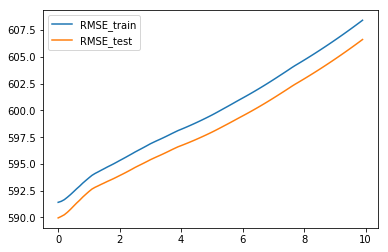

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(alpha_lst, RMSE_train)
plt.plot(alpha_lst, RMSE_test)
plt.legend(['RMSE_train', 'RMSE_test'], loc='upper left')
plt.show()

### Ridge Regression: find the best alpha

In [42]:
alpha_lst = np.arange(0, 10, 0.1)
RMSE_train = [0]*len(alpha_lst)
RMSE_test = [0]*len(alpha_lst)
from sklearn.linear_model import Ridge

for i in range(len(alpha_lst)):
    model_run = lin_model_ridge(X_train, Y_train, X_test, Y_test, alpha_lst[i])
    RMSE_train[i] = model_run[1]
    RMSE_test[i] = model_run[2]
print(RMSE_train,RMSE_test)

Root mean squared error for train: 3646728836586476355273733911347200.00
Root mean squared error for test: 3669287604680430600796716832653312.00
Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.42
Root mean squared error for test: 589.96
Root mean squared error for train: 591.42
Root mean squared error for test: 589.97
Root mean squared error for train: 591.42
Root mean squared error for test: 589.97
Root mean squared error f

Root mean squared error for train: 591.43
Root mean squared error for test: 589.99
Root mean squared error for train: 591.43
Root mean squared error for test: 589.99
[3.6467288365864764e+33, 591.4156453661747, 591.4158388623366, 591.4161040704823, 591.4164129606665, 591.416747223524, 591.4170947451921, 591.4174474518526, 591.4177999538373, 591.4181486719374, 591.4184912627586, 591.4188262340772, 591.4191526834818, 591.4194701185065, 591.4197783315072, 591.4200773118417, 591.4203671837944, 591.4206481624615, 591.4209205222905, 591.4211845746116, 591.4214406516002, 591.4216890948716, 591.4219302474248, 591.422164448019, 591.4223920273173, 591.4226133053218, 591.4228285897448, 591.4230381750614, 591.4232423420542, 591.4234413577096, 591.4236354753646, 591.4238249350261, 591.4240099638076, 591.4241907764408, 591.4243675758333, 591.4245405536485, 591.4247098908922, 591.4248757584944, 591.4250383178779, 591.4251977215094, 591.4253541134271, 591.4255076297444, 591.4256583991295, 591.425806543

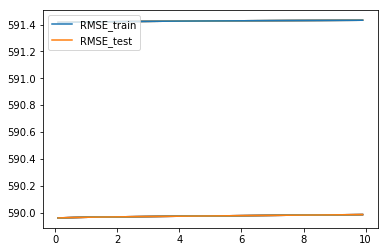

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(alpha_lst[1:], RMSE_train[1:])
plt.plot(alpha_lst[1:], RMSE_test[1:])
plt.legend(['RMSE_train', 'RMSE_test'], loc='upper left')
plt.show()

### Random Forest Model

In [34]:
from sklearn.ensemble import RandomForestRegressor
rf_model = rf_model(X_train, Y_train, X_test, Y_test)

Root mean squared error for train: 665.47
Root mean squared error for test: 664.68


### Grid Search best hyper parameters for RF model

In [57]:
best_parameters_rf = rf_model_grid_search(X_train, Y_train)

0.186093201827
{'bootstrap': True, 'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 1000}


In [60]:
best_parameters_rf

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 20,
 'min_samples_leaf': 10,
 'min_samples_split': 50,
 'n_estimators': 1000}

### Fit the RF model using best parameters found

In [61]:
rf_model_best = rf_with_best_parameters(X_train, Y_train, X_test, Y_test,best_parameters_rf)

Root mean squared error for train: 644.90
Root mean squared error for test: 644.03


### GBM model

In [35]:
from sklearn import ensemble
gbm_model = gbm_model(X_train, Y_train, X_test, Y_test)

Root mean squared error for train: 600.67
Root mean squared error for test: 602.05


### Grid Search best hyper parameters for GBM model

In [56]:
best_parameters_gbm = gbm_model_grid_search(X_train, Y_train)

0.381693403666
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10}


### Fit the GBM model using best parameters found

In [58]:
gbm_model_best = gbm_with_best_parameters(X_train, Y_train, X_test, Y_test,best_parameters_gbm)

Root mean squared error for train: 563.85
Root mean squared error for test: 571.78


### Since GBM model achieves the best performance, refit GBM using all training set

In [60]:
gbm_model_use = gbm_with_best_parameters_whole_train_set(Train_ready_encoded, target_in_train, best_parameters_gbm)

Root mean squared error for train: 566.91


## Model persistence

### Save Trained GBM model to local folder

In [61]:
joblib.dump(gbm_model_use, 'gbm_model_saved.pkl')

['gbm_model_saved.pkl']

### Testing: load the saved GBM model and make some predictions

In [62]:
gbm_pred = make_prediction('gbm_model_saved.pkl', X_test)

In [65]:
print(len(gbm_pred))

78969


In [66]:
gbm_pred[:20]

array([ 2293.50835784,  2838.62334103,  2251.74874425,  2240.7351142 ,
        2416.20007106,  2501.93681813,  2561.08997439,  2275.75416258,
        2998.79859211,  2248.73661143,  3098.01418079,  2359.43527697,
        2831.39361821,  2402.98098392,  3033.23640343,  3122.78087725,
        2559.8937146 ,  2720.02531779,  2467.67426725,  2498.88182806])